# Loading dataset

In [22]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from config import ShipDetection_config as conf

In [23]:
# ATTENTION: The config file is located in ShipDetection/segmentation_models.tensorflow/examples/config/

DATA_DIR = (conf.IMAGES_PATH)

x_train_dir = (conf.TRAIN_IMG)
y_train_dir = (conf.TRAIN_MSK)

x_valid_dir = (conf.VAL_IMG)
y_valid_dir = (conf.VAL_MSK)

x_test_dir = (conf.TEST_IMG)
y_test_dir = (conf.TEST_MSK)


# Dataloader and utility functions 

In [24]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['ship']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids_img = os.listdir(images_dir)
        self.ids_msk = os.listdir(masks_dir)
        self.ids_img.sort()
        self.ids_msk.sort()
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_img]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids_msk]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        self.images_fps.sort()
        self.masks_fps.sort()

        image = cv2.imread(self.images_fps[i], cv2.COLOR_BGR2RGB)
        if (image is not None):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i], 0)
        if (mask is not None):
            # extract certain classes from mask (e.g. cars)
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
          
        return image, mask
        
    def __len__(self):
        return len(self.ids_img)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):   
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

### Augmentations

In [19]:
#import albumentations as A

In [44]:
#def round_clip_0_1(x, **kwargs):
#    return x.round().clip(0, 1)
#
## define heavy augmentations
#def get_training_augmentation():
#    train_transform = [
#
#        A.HorizontalFlip(p=0.5),
#
#        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
#
#        #A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#        #A.RandomCrop(height=320, width=320, always_apply=True),
#        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
#        A.RandomCrop(height=128, width=128, always_apply=True),
#
#        A.IAAAdditiveGaussianNoise(p=0.2),
#        A.IAAPerspective(p=0.5),
#
#        A.OneOf(
#            [
#                A.CLAHE(p=1),
#                A.RandomBrightness(p=1),
#                A.RandomGamma(p=1),
#            ],
#            p=0.9,
#        ),
#
#        A.OneOf(
#            [
#                A.IAASharpen(p=1),
#                A.Blur(blur_limit=3, p=1),
#                A.MotionBlur(blur_limit=3, p=1),
#            ],
#            p=0.9,
#        ),
#
#        A.OneOf(
#            [
#                A.RandomContrast(p=1),
#                A.HueSaturationValue(p=1),
#            ],
#            p=0.9,
#        ),
#        A.Lambda(mask=round_clip_0_1)
#    ]
#    return A.Compose(train_transform)
#
#
#def get_validation_augmentation():
#    """Add paddings to make image shape divisible by 32"""
#    test_transform = [
#        A.PadIfNeeded(384, 480)
#    ]
#    return A.Compose(test_transform)
#
#def get_preprocessing(preprocessing_fn):
#    """Construct preprocessing transform
#    
#    Args:
#        preprocessing_fn (callbale): data normalization function 
#            (can be specific for each pretrained neural network)
#    Return:
#        transform: albumentations.Compose
#    
#    """
#    
#    _transform = [
#        A.Lambda(image=preprocessing_fn),
#    ]
#    return A.Compose(_transform)

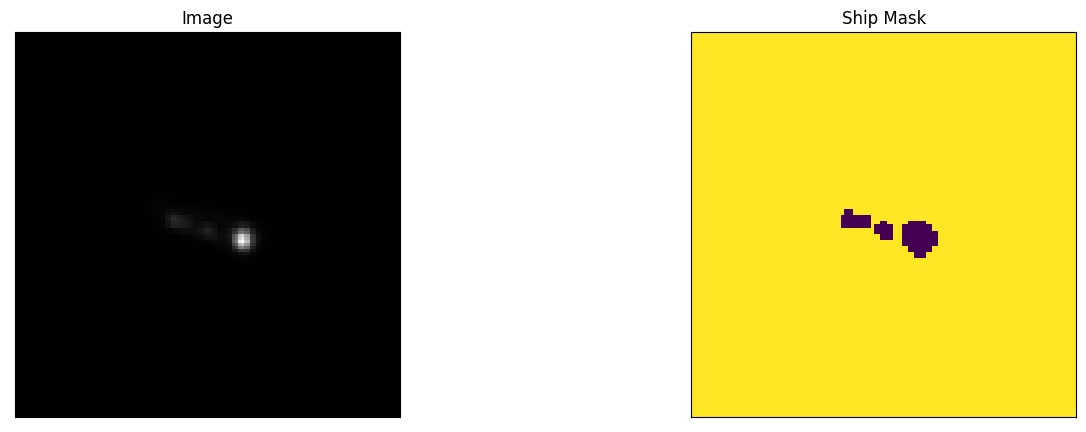

In [25]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['ship'])

assert os.path.exists(x_train_dir)

image, mask = dataset[random.randint(0, len(dataset))] # get some sample
visualize(
    image=image,
    ship_mask=mask.squeeze(), 
    )

# Segmentation model training

In [26]:
#%pip install segmentation_models
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [27]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['ship']
#LR = 0.0001
LR = 0.00005
#EPOCHS = 40
EPOCHS = 15

preprocess_input = sm.get_preprocessing(BACKBONE)

In [28]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [29]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [30]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [13]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/15


2022-10-23 11:49:28.393910: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-10-23 11:49:28.886112: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


518/518 [==============================] - 53s 75ms/step - loss: 0.1574 - iou_score: 0.9495 - f1-score: 0.9718 - val_loss: 0.0919 - val_iou_score: 0.9883 - val_f1-score: 0.9939 - lr: 5.0000e-05
Epoch 2/15
518/518 [==============================] - 37s 71ms/step - loss: 0.0590 - iou_score: 0.9906 - f1-score: 0.9953 - val_loss: 0.0408 - val_iou_score: 0.9917 - val_f1-score: 0.9958 - lr: 5.0000e-05
Epoch 3/15
518/518 [==============================] - 38s 73ms/step - loss: 0.0317 - iou_score: 0.9924 - f1-score: 0.9962 - val_loss: 0.0252 - val_iou_score: 0.9924 - val_f1-score: 0.9961 - lr: 5.0000e-05
Epoch 4/15
518/518 [==============================] - 36s 70ms/step - loss: 0.0205 - iou_score: 0.9933 - f1-score: 0.9967 - val_loss: 0.0179 - val_iou_score: 0.9931 - val_f1-score: 0.9965 - lr: 5.0000e-05
Epoch 5/15
518/518 [==============================] - 37s 71ms/step - loss: 0.0149 - iou_score: 0.9941 - f1-score: 0.9970 - val_loss: 0.0147 - val_iou_score: 0.9933 - val_f1-score: 0.9966 - l

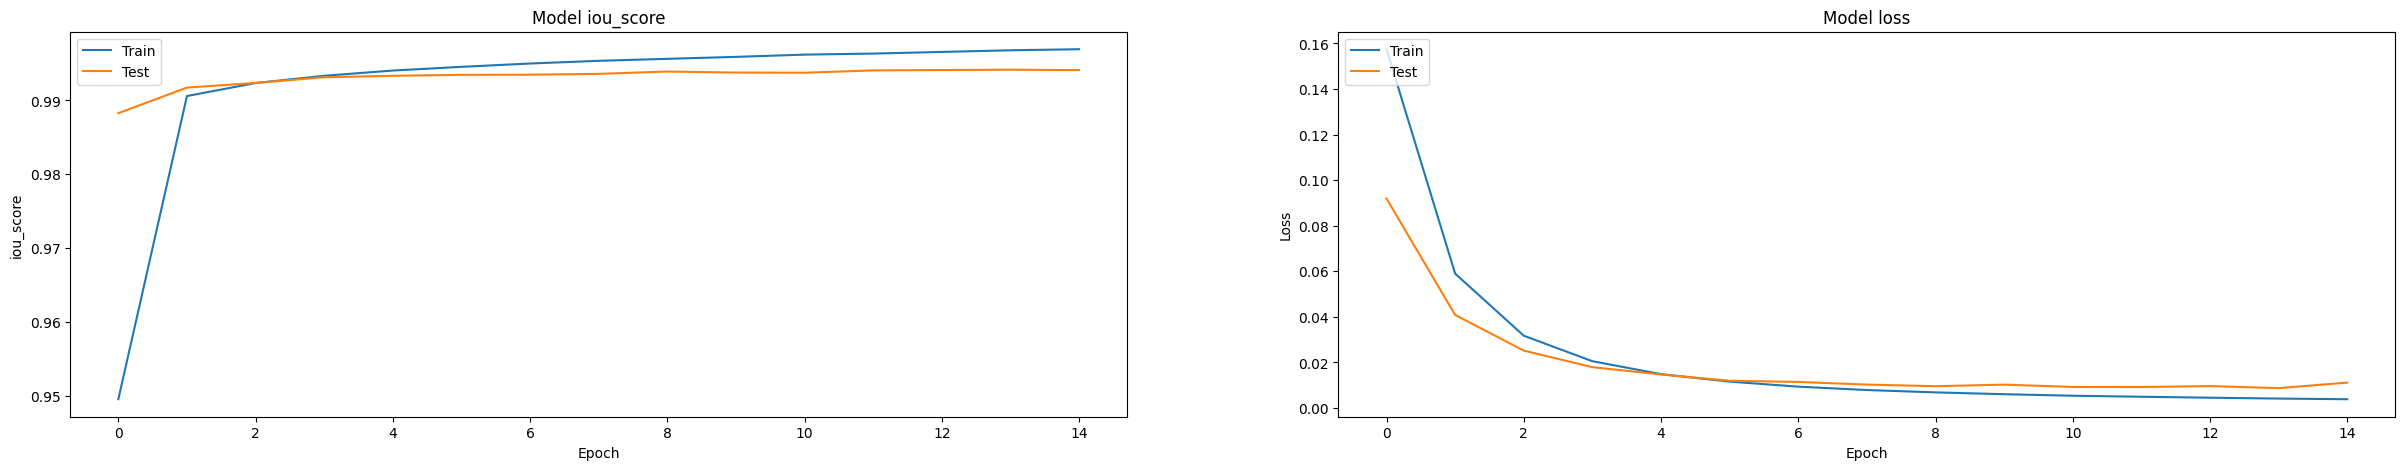

In [14]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [15]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [16]:
# load best weights
model.load_weights('best_model.h5') 

In [17]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

1385/1385 [==============================] - 14s 10ms/step - loss: 0.0077 - iou_score: 0.9947 - f1-score: 0.9973
Loss: 0.0077105
mean iou_score: 0.99465
mean f1-score: 0.99731


# Visualization of results on test dataset

1/1 [==============================] - 0s 17ms/step


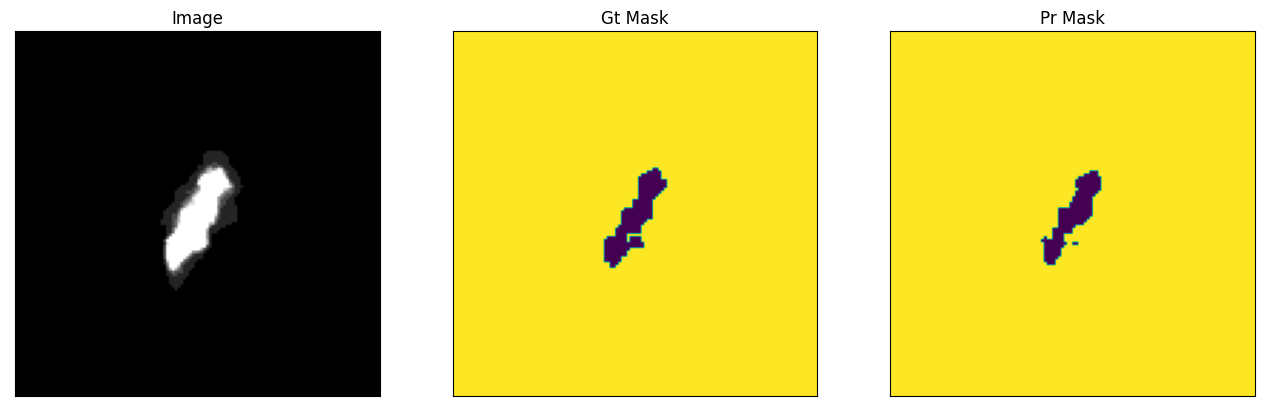

1/1 [==============================] - 0s 23ms/step


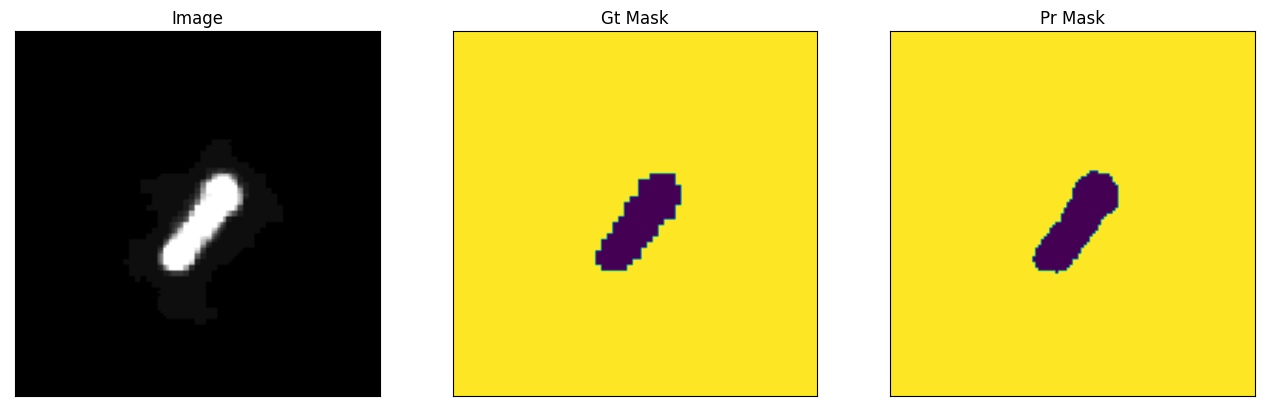

1/1 [==============================] - 0s 23ms/step


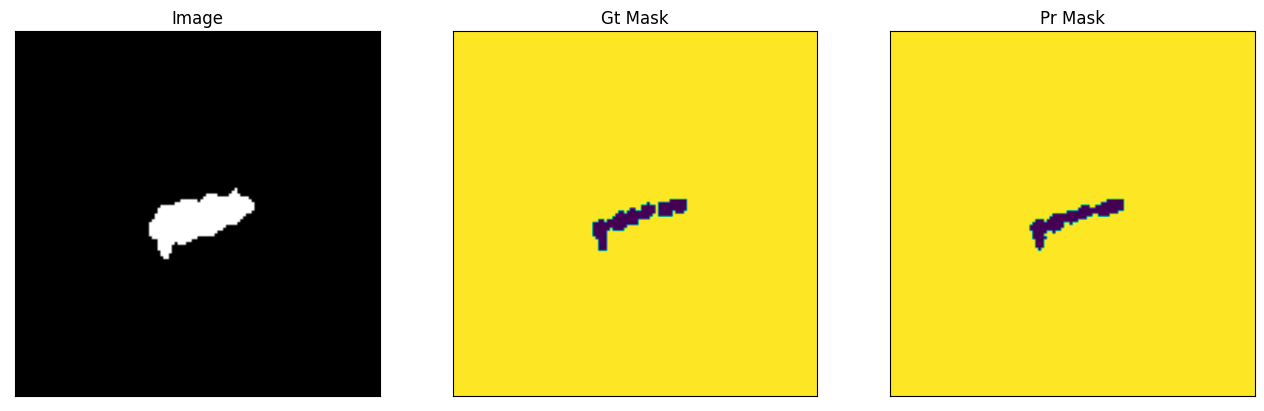

1/1 [==============================] - 0s 17ms/step


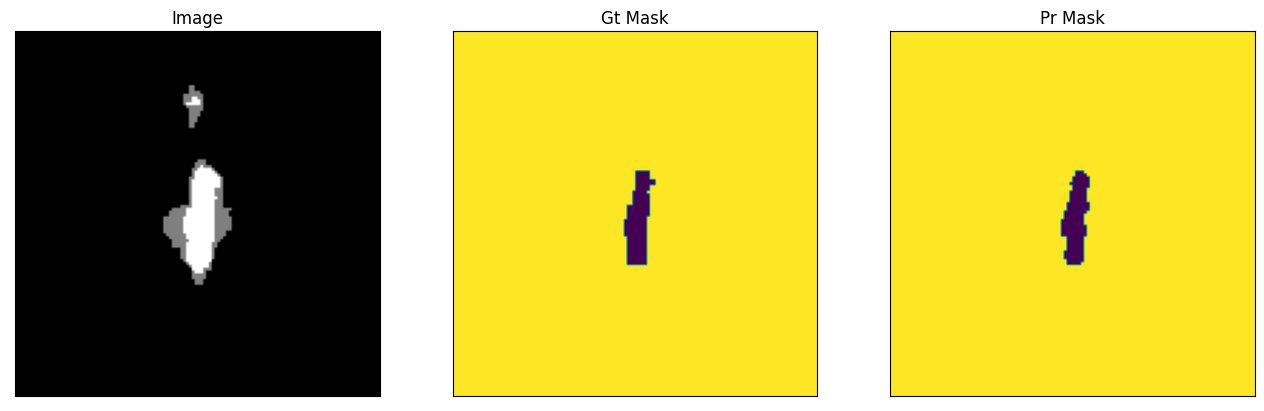

1/1 [==============================] - 0s 17ms/step


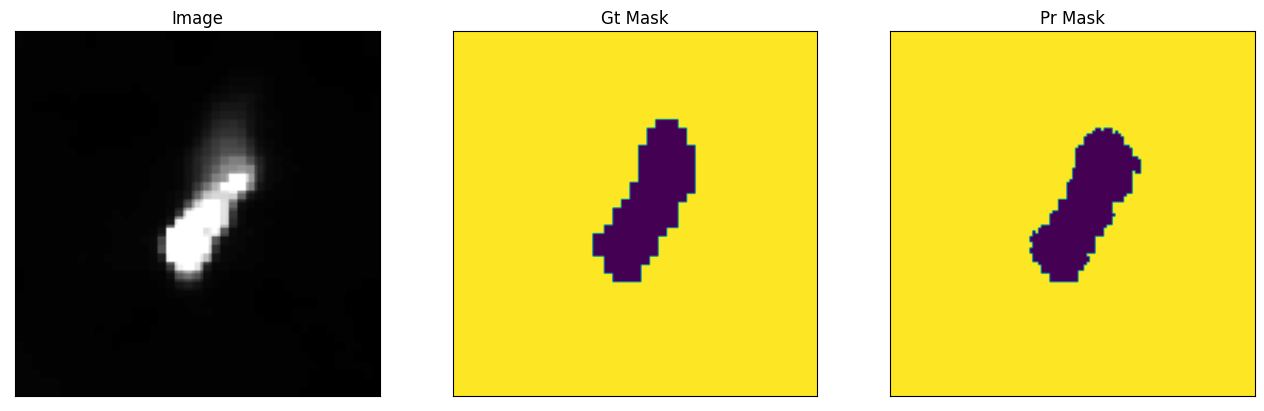

In [21]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )